In [1]:
import os
import sys

# data manipulation libraries
import pandas as pd
import numpy as np

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning libraries
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

# import scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans # import k-means algorithm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.identify_missing_data import identify_missing_data
from src.helpers import identify_number_categories, identify_highly_correlated_features, identify_low_variance_features, one_hot
from src.feature_importance_plot import feature_importance_plot
from src.learning_curve_plot import learning_curve_plot
from src.utils import encode_genre

from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

In [2]:
# # STEP 1 - Data Extraction
raw_data = pd.read_csv("../data/songs_data.csv")

In [3]:
# STEP 2 - Exploratory data analysis

## First look on the data. Note the main caracteristics of the data: 16 features, 1 that needs to be predicted (genre) our target 

### It should also be noted that not every feature is numeric, which will ask for enconding later. 

#### There are a few missing data that will also be addressed later in the project

raw_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28396 entries, 0 to 28395
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          28396 non-null  object 
 1   track_name        28392 non-null  object 
 2   track_artist      28392 non-null  object 
 3   track_popularity  28396 non-null  int64  
 4   genre             28396 non-null  object 
 5   danceability      28396 non-null  float64
 6   energy            28396 non-null  float64
 7   key               28396 non-null  int64  
 8   loudness          28396 non-null  float64
 9   mode              28396 non-null  int64  
 10  speechiness       28396 non-null  float64
 11  acousticness      28396 non-null  float64
 12  instrumentalness  28396 non-null  float64
 13  liveness          28396 non-null  float64
 14  valence           28396 non-null  float64
 15  tempo             28396 non-null  float64
 16  duration_ms       28396 non-null  int64 

In [4]:
pd.set_option('display.max_columns', None)
raw_data

,track_id,track_name,track_artist,track_popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6ho0GyrWZN3mhi9zVRW7xi,Losing It,FISHER,79,edm,0.760,0.964,2,-5.844,1,0.0576,0.001820,0.700000,0.0974,0.6410,125.000,248036
1,4bYJKHG6KLdGzHQRJMaFc8,Rock And Roll All Nite,KISS,3,rock,0.581,0.831,1,-8.045,1,0.1070,0.045800,0.000000,0.0782,0.8850,144.684,168160
2,1VGlMYqPO1LHyclvfIMvWI,Snälla bli min (Hjalm Remix),Robin Lukovic,0,edm,0.661,0.760,8,-4.769,1,0.0268,0.000406,0.040700,0.6110,0.4390,99.993,271238
3,6BbINUfGabVyiNFJpQXn3x,Wicked,Future,62,rap,0.718,0.679,11,-5.899,0,0.0706,0.001910,0.010400,0.3850,0.2050,157.970,173347
4,1Ly0ssAgeM7YqdHptao8Oe,Paranoid,Black Sabbath,15,rock,0.426,0.619,4,-11.501,0,0.0722,0.000084,0.002390,0.1700,0.3820,162.721,168440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28391,639L1OUV4JRqnPHaQaziYO,Black Water,Massface,35,rock,0.253,0.931,11,-3.093,1,0.0616,0.000595,0.002170,0.0978,0.3320,194.911,208077
28392,4bQGI1roeSr8Q85on2tQNU,Lean On Me,Club Nouveau,2,r&b,0.748,0.629,0,-8.420,1,0.0660,0.016800,0.000000,0.0991,0.9190,182.448,294947
28393,32gaGfRgDMrMtcpCqF078U,Morning Dew,Matt Quentin,58,pop,0.686,0.332,9,-11.759,1,0.0454,0.890000,0.342000,0.1070,0.0745,80.994,237037
28394,7At7pljkrkgjwy0utWu2xx,eoh (Theis EZ Remix),Hallasen,33,edm,0.845,0.505,10,-5.481,1,0.0516,0.057500,0.000424,0.0335,0.2050,125.037,143095


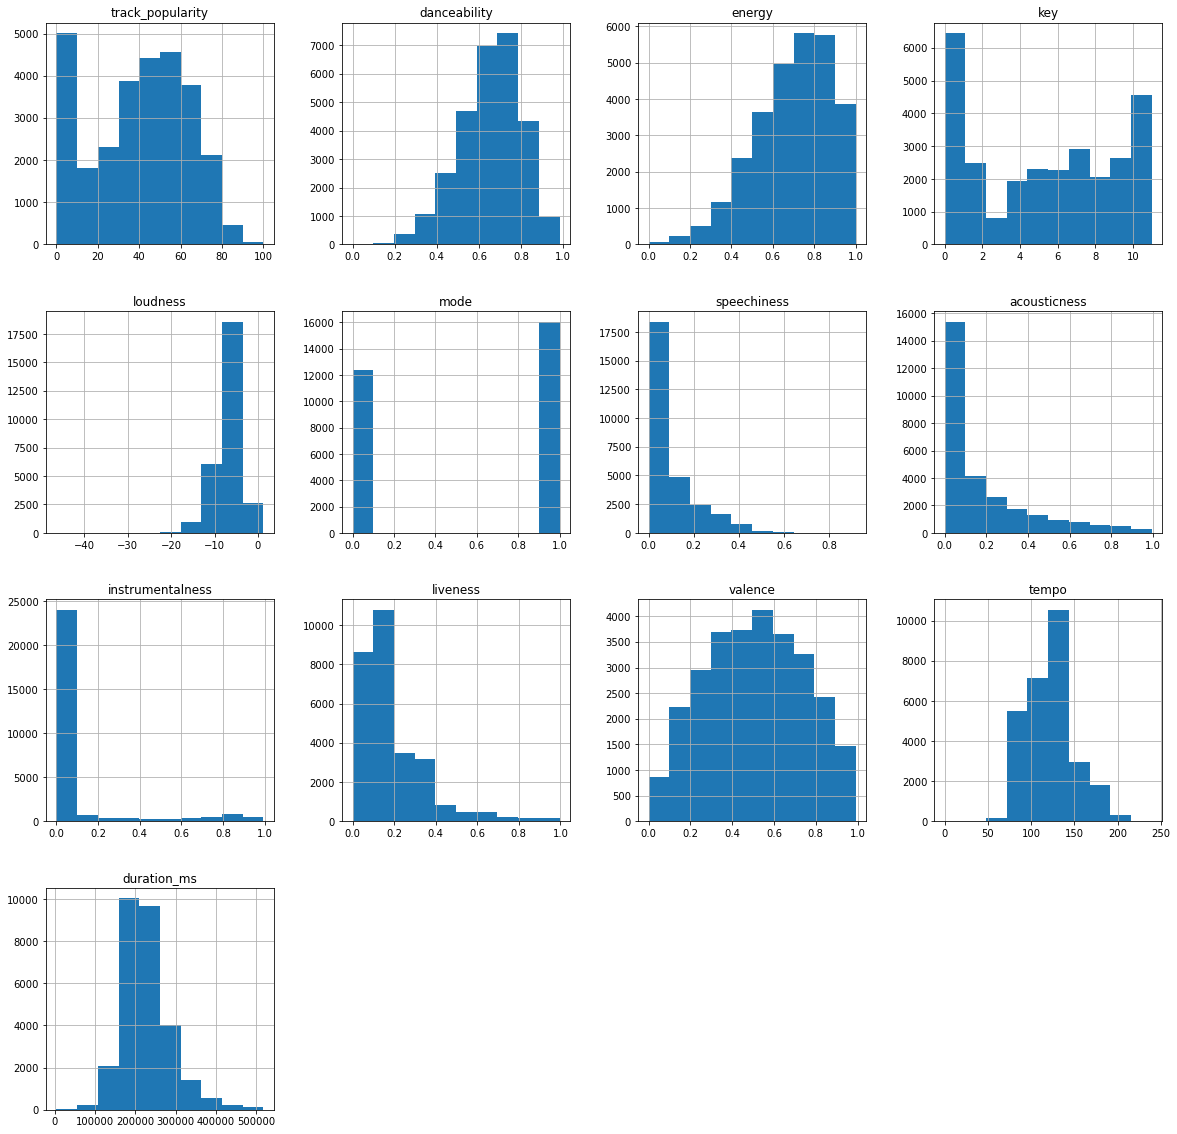

In [5]:
plt.rcParams["figure.figsize"] = (20,20)
raw_data.hist();

In [6]:
raw_data.corr()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
track_popularity,1.000000,0.047098,-0.103602,-0.008036,0.037750,0.016263,0.005324,0.091586,-0.124404,-0.053274,0.022792,0.003901,-0.139895
danceability,0.047098,1.000000,-0.081461,0.006925,0.015393,-0.055483,0.183176,-0.028739,-0.002592,-0.127255,0.333792,-0.184915,-0.087915
energy,-0.103602,-0.081461,1.000000,0.013084,0.682215,-0.004481,-0.028745,-0.546013,0.022918,0.163371,0.149810,0.151564,0.017810
key,-0.008036,0.006925,0.013084,1.000000,-0.000203,-0.176383,0.022746,0.004401,0.007432,0.001829,0.021763,-0.010953,0.018837
loudness,0.037750,0.015393,0.682215,-0.000203,1.000000,-0.017972,0.013156,-0.371738,-0.154991,0.081526,0.049863,0.096519,-0.104495
mode,0.016263,-0.055483,-0.004481,-0.176383,-0.017972,1.000000,-0.059651,0.006885,-0.005740,-0.000307,-0.003099,0.017061,0.012427
speechiness,0.005324,0.183176,-0.028745,0.022746,0.013156,-0.059651,1.000000,0.024509,-0.108187,0.059995,0.064879,0.032835,-0.097944
acousticness,0.091586,-0.028739,-0.546013,0.004401,-0.371738,0.006885,0.024509,1.000000,-0.001884,-0.074659,-0.019402,-0.114503,-0.094430
instrumentalness,-0.124404,-0.002592,0.022918,0.007432,-0.154991,-0.005740,-0.108187,-0.001884,1.000000,-0.008735,-0.174410,0.021225,0.058933
liveness,-0.053274,-0.127255,0.163371,0.001829,0.081526,-0.000307,0.059995,-0.074659,-0.008735,1.000000,-0.019668,0.022690,0.008551


In [7]:
# STEP 3 & 4 - Data cleaning and feature engineering
# Identifying all missing data

missing_value_df = identify_missing_data(raw_data)
missing_value_df_reduced = missing_value_df[missing_value_df.percent_missing > 0]
categorical_cols = list(missing_value_df_reduced[missing_value_df_reduced.data_type == 'object'].feature)
for c in categorical_cols:
    print("replacing missing values for:", c)
    raw_data[c].fillna('Unknown', inplace=True)

replacing missing values for: track_artist
replacing missing values for: track_name


In [8]:
# identifying all the non numerical features

categorical_columns=list(raw_data.select_dtypes(['object']).columns)
categorical_columns

['track_id', 'track_name', 'track_artist', 'genre']

In [9]:
# droping columns that are object, and probably not useful in predicting genre 
# (one artist can have musics in many different genres, for example)
cols_to_drop = ['track_id', 'track_name', 'track_artist']

In [10]:
identify_number_categories(raw_data)

,categorical_feature,number_categories
0,track_id,28356
1,track_name,23450
2,track_artist,10693
3,genre,6


In [11]:
# encoding of the categorical data with our own function
#songs_encoded=encode_genre(raw_data)
songs_encoded = one_hot(raw_data, ['genre'])

In [12]:
#songs_encoded.corr()

In [13]:
#    There are not many highly correlated features, and thus this step is just to visualize some minor influences that some
# features might have, like loudness and r&b: while 0.17 correlation does not show a very big influence of the feature,
# it shows that it has a part on defining it, while speechness=0.42 is not that strong an influence on rap, but
# probably (and intuitively) it is a big feature of the genre

# corr_df = identify_highly_correlated_features(songs_encoded, correlation_threshold=0.3)
# corr_df

In [14]:
identify_low_variance_features(songs_encoded,std_threshold=0.2)

number of low variance features: 4
low variance features: ['danceability', 'energy', 'speechiness', 'liveness']


C:\Users\guilh\Documents\HKA\IP302\project\src\helpers.py:75: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std_df = pd.DataFrame(df.std()).rename(columns = {0: 'standard_deviation'})


['danceability', 'energy', 'speechiness', 'liveness']

In [15]:
songs_encoded.shape

(28396, 22)

In [16]:
songs_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28396 entries, 0 to 28395
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          28396 non-null  object 
 1   track_name        28396 non-null  object 
 2   track_artist      28396 non-null  object 
 3   track_popularity  28396 non-null  int64  
 4   danceability      28396 non-null  float64
 5   energy            28396 non-null  float64
 6   key               28396 non-null  int64  
 7   loudness          28396 non-null  float64
 8   mode              28396 non-null  int64  
 9   speechiness       28396 non-null  float64
 10  acousticness      28396 non-null  float64
 11  instrumentalness  28396 non-null  float64
 12  liveness          28396 non-null  float64
 13  valence           28396 non-null  float64
 14  tempo             28396 non-null  float64
 15  duration_ms       28396 non-null  int64  
 16  genre_edm         28396 non-null  uint8 

In [17]:
identify_missing_data(raw_data)

,feature,percent_missing,data_type
0,track_id,0.0,object
1,mode,0.0,int64
2,tempo,0.0,float64
3,valence,0.0,float64
4,liveness,0.0,float64
5,instrumentalness,0.0,float64
6,acousticness,0.0,float64
7,speechiness,0.0,float64
8,loudness,0.0,float64
9,track_name,0.0,object


In [18]:
# Feature engineering for random forest

final_table = songs_encoded.drop(cols_to_drop, axis=1)
cols_to_drop_2 = [
                  #'danceability',
                  #'tempo',
                  #'energy',
                  #'speechiness',
                  #'instrumentalness',
                  'track_popularity', 
                  'key', 
                  'mode', 
                  #'liveness', 
                  'loudness', 
                  #'acousticness', 
                  #'valence', 
                  'duration_ms'
                 ]
final_table = final_table.drop(cols_to_drop_2, axis=1)
final_table

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre_edm,genre_latin,genre_pop,genre_r&b,genre_rap,genre_rock
0,0.760,0.964,0.0576,0.001820,0.700000,0.0974,0.6410,125.000,1,0,0,0,0,0
1,0.581,0.831,0.1070,0.045800,0.000000,0.0782,0.8850,144.684,0,0,0,0,0,1
2,0.661,0.760,0.0268,0.000406,0.040700,0.6110,0.4390,99.993,1,0,0,0,0,0
3,0.718,0.679,0.0706,0.001910,0.010400,0.3850,0.2050,157.970,0,0,0,0,1,0
4,0.426,0.619,0.0722,0.000084,0.002390,0.1700,0.3820,162.721,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28391,0.253,0.931,0.0616,0.000595,0.002170,0.0978,0.3320,194.911,0,0,0,0,0,1
28392,0.748,0.629,0.0660,0.016800,0.000000,0.0991,0.9190,182.448,0,0,0,1,0,0
28393,0.686,0.332,0.0454,0.890000,0.342000,0.1070,0.0745,80.994,0,0,1,0,0,0
28394,0.845,0.505,0.0516,0.057500,0.000424,0.0335,0.2050,125.037,1,0,0,0,0,0


In [19]:
# Feature engineering for Hierarchy clustering (scaling and normalizing)
sc = StandardScaler()
df_scaled = sc.fit_transform(final_table)
df_normalized = normalize(df_scaled)

In [20]:
target_edm = final_table.genre_edm
target_pop = final_table.genre_pop
target_reb = final_table['genre_r&b']
target_rap = final_table.genre_rap
target_rock = final_table.genre_rock
target_latin = final_table.genre_latin
genres = ['genre_edm', 'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock', 'genre_latin']
features = final_table.drop(genres, axis =1)

In [21]:
print("Target shape: ", target_edm.shape)
print("Target shape: ", target_pop.shape)
print("Target shape: ", target_reb.shape)
print("Target shape: ", target_rap.shape)
print("Target shape: ", target_rock.shape)
print("Target shape: ", target_latin.shape)
print("Features shape: ", features.shape)

Target shape:  (28396,)
Target shape:  (28396,)
Target shape:  (28396,)
Target shape:  (28396,)
Target shape:  (28396,)
Target shape:  (28396,)
Features shape:  (28396, 8)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target_edm,
                                                test_size = 0.1, 
                                                random_state = 8)

In [23]:
print("Training Data")
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)

Training Data
Shape of X_train (25556, 8)
Shape of y_train (25556,)


In [24]:
print("Test Data")
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)


Test Data
Shape of X_test (2840, 8)
Shape of y_test (2840,)


In [25]:
# STEP 5 - Model training
#model = RandomForestClassifier()
model = XGBClassifier()
#model = DecisionTreeClassifier()


In [26]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [27]:
# STEP 6 - Performance evaluation
# Generating predictions
y_pred_dt = model.predict(X_test)
y_pred_dt

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
#evaluation metrics
r2_score(y_test, y_pred_dt)

0.38403490419016695

In [29]:
mean_absolute_error(y_test, y_pred_dt)

0.08169014084507042

In [30]:
mean_squared_error(y_test, y_pred_dt)

0.08169014084507042

In [31]:
r2 = r2_score(y_test, y_pred_dt)
print("R2:", round(r2, 2))
mae = mean_absolute_error(y_test, y_pred_dt)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_test, y_pred_dt)
print("Mean Squared Error:", round(mse))

R2: 0.38
Mean Absolute Error: 0
Mean Squared Error: 0


In [32]:
# the evaluation metrics on the training set

y_pred_train_dt = model.predict(X_train)

print("Model performance on Training Set")
r2 = r2_score(y_train, y_pred_train_dt)
print("R2:", round(r2, 2))
mae = mean_absolute_error(y_train, y_pred_train_dt)
print("Mean Absolute Error:", round(mae))
mse = mean_squared_error(y_train, y_pred_train_dt)
print("Mean Squared Error:", round(mse))

Model performance on Training Set
R2: 0.61
Mean Absolute Error: 0
Mean Squared Error: 0


In [33]:
pd.set_option('display.max_rows', None)
y_pred_dt

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
y_test

27133    0
11408    0
19626    0
15341    1
14375    1
27026    0
18255    0
11139    1
17512    0
1306     0
8086     0
3762     0
19478    0
6401     0
13339    0
24284    0
17157    0
12472    0
16814    1
20856    0
19465    0
23303    0
2148     1
27583    0
16995    0
21011    1
25387    0
14017    0
14753    0
22368    0
14529    0
13954    0
18441    0
18381    0
2236     0
2030     0
11461    0
23094    0
14777    0
13836    0
16250    0
25380    0
26799    0
9451     0
10533    0
1258     0
9563     0
2206     0
16347    1
26537    0
14209    0
24729    0
13010    0
9110     0
3919     0
1376     0
15361    0
20870    1
1854     0
13211    0
10492    0
10362    0
19876    0
24029    0
14451    0
26372    0
7816     0
1072     0
14732    0
20471    0
25848    1
23023    0
18110    0
16998    1
17758    0
3199     0
18950    0
19437    0
27976    0
19799    0
6444     0
2427     0
12503    0
5542     1
10374    0
21857    0
25122    0
6499     0
16206    0
8903     0
27451    0

In [35]:
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_normalized)
df_pca = pd.DataFrame(df_pca)
df_pca.columns = ['P1', 'P2', 'P3']

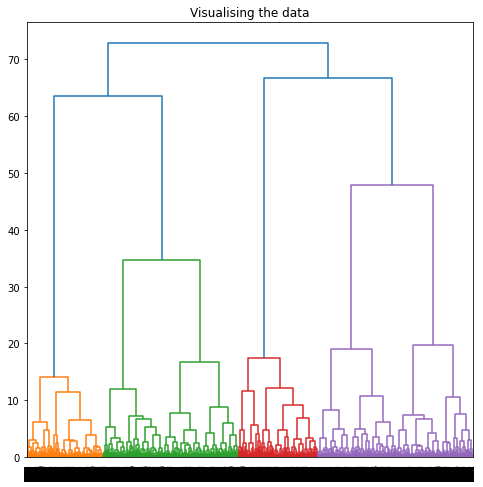

In [36]:
plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
dendrogram = hc.dendrogram((hc.linkage(df_pca, method ='ward')))

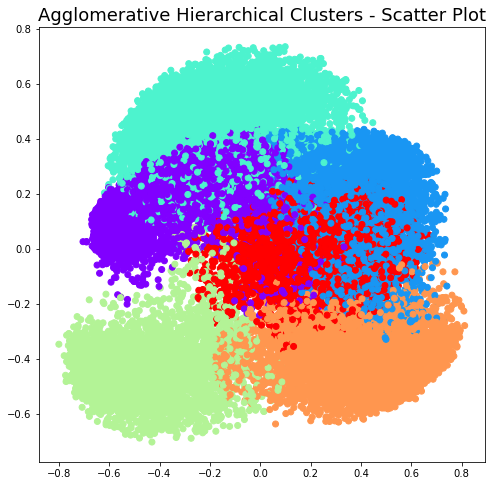

In [37]:
#
# Create the clusters using Agglomerative hierarchical clustering
#
agc = AgglomerativeClustering(n_clusters = 6)
plt.figure(figsize =(8, 8))
plt.scatter(df_pca['P1'], df_pca['P2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title("Agglomerative Hierarchical Clusters - Scatter Plot", fontsize=18)
plt.show()